# 1.Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
# Import standarrd dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [74]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

^C


In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collective Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
uuid.uuid1()

UUID('bae86a72-5db8-11ee-abf1-90e868418444')

In [51]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[100:100+250, 140:140+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # show image back to the screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

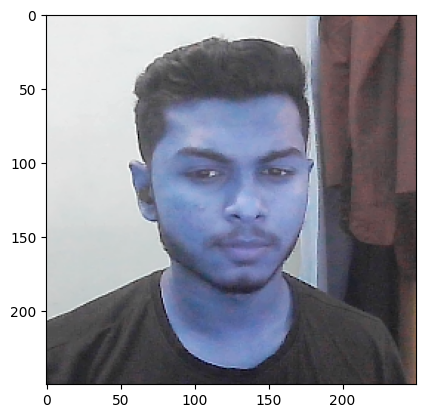

In [45]:
plt.imshow(frame[100:100+250, 140:140+250, :])

# 2.x NEW - Data Augmentation 

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [12]:
img_path = os.path.join(ANC_PATH, '2a933433-5878-11ee-bac0-90e868418444.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [13]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [11]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
print(dir_test.next())

b'data\\anchor\\0b4080ca-5dba-11ee-8cdb-90e868418444.jpg'


## 3.2 Preprocessing - Scale and Resize

In [17]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [65]:
img = preprocess('data\\anchor\\0b4080ca-5dba-11ee-8cdb-90e868418444.jpg')

In [66]:
img.numpy().max()

0.9514706

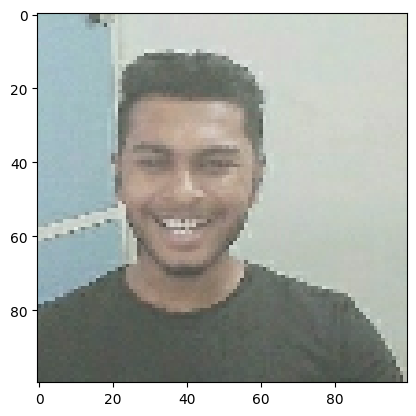

In [67]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
samples = data.as_numpy_iterator()

In [23]:
example = samples.next()

In [24]:
example

(b'data\\anchor\\fe849b98-5db9-11ee-aaa1-90e868418444.jpg',
 b'data\\positive\\31611076-5db9-11ee-9518-90e868418444.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*example)

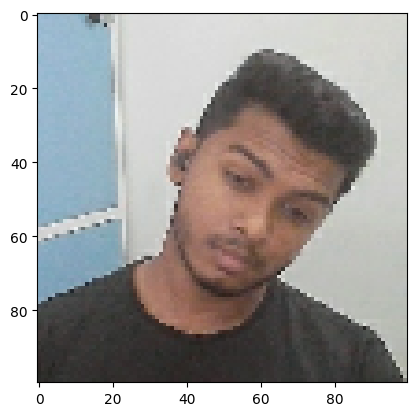

In [68]:
plt.imshow(res[1])

In [24]:
res[2]

1.0

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [28]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

## Build Embedding Layer

In [30]:
inp = Input(shape=(100, 100, 3), name='input_image')

In [31]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [32]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [33]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [34]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [35]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [36]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [38]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [39]:
embedding = make_embedding()

In [40]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [41]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [42]:
l1 = L1Dist()

In [43]:
l1

## 4.3 Make Siamese Model

In [44]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [45]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
distances = siamese_layer(inp_embedding, val_embedding)

In [48]:
classifier = Dense(1, activation='sigmoid')(distances)

In [49]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [50]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [52]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_model = make_siamese_model()

In [54]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training 

## 5.1 Setup Loss and Opyimizer

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [56]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [58]:
test_batch = train_data.as_numpy_iterator()

In [59]:
batch_1 = test_batch.next()

In [60]:
X = batch_1[:2]

In [61]:
y = batch_1[2]

In [62]:
y

array([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

In [102]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [63]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [69]:
# Import Metrics calculations 
from tensorflow.keras.metrics import Precision, Recall

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [71]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 3419s 13s/step
0.024419066 0.9151659 0.9928021

 Epoch 2/50
263/263 [==============================] - 3400s 13s/step
0.01899482 0.97779924 0.99070907

 Epoch 3/50
263/263 [==============================] - 3402s 13s/step
0.044831425 0.9919317 0.99523807

 Epoch 4/50
263/263 [==============================] - 3418s 13s/step
0.038226314 0.9909308 0.9899857

 Epoch 5/50
263/263 [==============================] - 3459s 13s/step
0.032715492 0.98257184 0.9938066

 Epoch 6/50
 69/263 [======>.......................] - ETA: 43:14

KeyboardInterrupt: 

## 6. Evaluate Model

## 6.1 Import Metrics

In [73]:
# Import Metrics calculations 
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [74]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [75]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 648ms/step


array([[9.9998355e-01],
       [2.6268165e-07],
       [7.5214106e-01],
       [9.9992383e-01],
       [9.4327563e-03],
       [9.4654220e-01],
       [3.4338202e-05],
       [8.8822252e-01],
       [1.6837633e-06],
       [9.9909151e-01],
       [2.4532084e-04],
       [4.9609895e-07],
       [9.9985826e-01],
       [9.9600625e-01],
       [9.9994624e-01],
       [9.7917908e-01]], dtype=float32)

In [76]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]

In [77]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [78]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [79]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [80]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 425ms/step
1.0 0.9966216


## 6.4 Visualizing Results

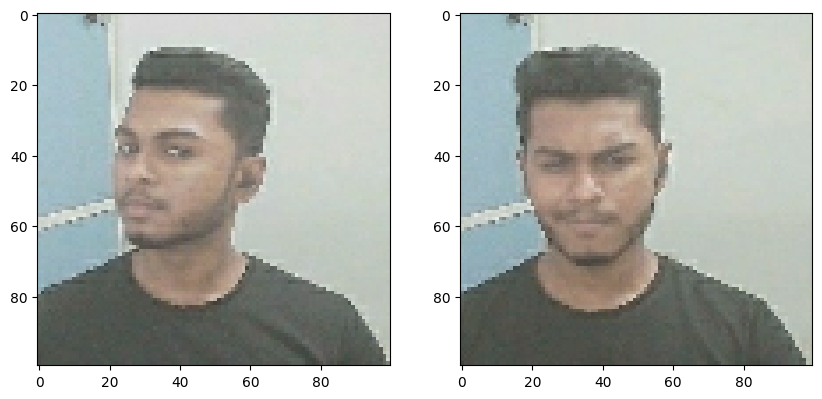

In [85]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

## 7. Save Model

In [86]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
L1Dist

__main__.L1Dist

In [88]:
# Reload model 
model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [89]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 429ms/step


array([[8.8477856e-01],
       [4.4945841e-07],
       [3.8405899e-05],
       [9.6425641e-01],
       [3.8305551e-08],
       [1.4054532e-07],
       [3.4292156e-05],
       [4.7380367e-05]], dtype=float32)

In [90]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test 

## 8.1 Verification Function

In [91]:
os.listdir(os.path.join('application_data', 'verification_images'))

['03ab6ecc-5879-11ee-9aa5-90e868418444.jpg',
 '08b7f550-5879-11ee-88e2-90e868418444.jpg',
 '09ff9d50-5879-11ee-92fa-90e868418444.jpg',
 '0a12a1cb-5879-11ee-aa0c-90e868418444.jpg',
 '0a31cd39-5879-11ee-a147-90e868418444.jpg',
 '0a55271a-5879-11ee-9591-90e868418444.jpg',
 '0a7d68b3-5879-11ee-990f-90e868418444.jpg',
 '0aaf4f2f-5879-11ee-8d58-90e868418444.jpg',
 '0ad7c4cf-5879-11ee-930b-90e868418444.jpg',
 '0b04d257-5879-11ee-9c94-90e868418444.jpg',
 '0b286d09-5879-11ee-8f86-90e868418444.jpg',
 '0b559f35-5879-11ee-81ab-90e868418444.jpg',
 '0b7e11ed-5879-11ee-8e95-90e868418444.jpg',
 '0b9a7dad-5879-11ee-bb91-90e868418444.jpg',
 '0c37182d-5879-11ee-8c86-90e868418444.jpg',
 '0c700e9c-5879-11ee-9aa8-90e868418444.jpg',
 '0c8c786f-5879-11ee-934f-90e868418444.jpg',
 '0c9d3c97-5879-11ee-9199-90e868418444.jpg',
 '0cb99925-5879-11ee-8205-90e868418444.jpg',
 '0f2498da-5879-11ee-ae83-90e868418444.jpg',
 '0f8667bb-5879-11ee-8328-90e868418444.jpg',
 '0fb3dc44-5879-11ee-a32f-90e868418444.jpg',
 '0fe5cec0

In [92]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [93]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\03ab6ecc-5879-11ee-9aa5-90e868418444.jpg
application_data\verification_images\08b7f550-5879-11ee-88e2-90e868418444.jpg
application_data\verification_images\09ff9d50-5879-11ee-92fa-90e868418444.jpg
application_data\verification_images\0a12a1cb-5879-11ee-aa0c-90e868418444.jpg
application_data\verification_images\0a31cd39-5879-11ee-a147-90e868418444.jpg
application_data\verification_images\0a55271a-5879-11ee-9591-90e868418444.jpg
application_data\verification_images\0a7d68b3-5879-11ee-990f-90e868418444.jpg
application_data\verification_images\0aaf4f2f-5879-11ee-8d58-90e868418444.jpg
application_data\verification_images\0ad7c4cf-5879-11ee-930b-90e868418444.jpg
application_data\verification_images\0b04d257-5879-11ee-9c94-90e868418444.jpg
application_data\verification_images\0b286d09-5879-11ee-8f86-90e868418444.jpg
application_data\verification_images\0b559f35-5879-11ee-81ab-90e868418444.jpg
application_data\verification_images\0b7e11ed-5879-11ee-8e95-90e

In [94]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [95]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.000002, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 248ms/step
False
1/1 [==============================] - 0s 246ms/step
True
1/1 [==============================] - 0s 237ms/step
True


In [105]:
np.sum(np.squeeze(results) > 0.000003)

33

In [106]:
results

[array([[7.341682e-07]], dtype=float32),
 array([[2.7873764e-05]], dtype=float32),
 array([[2.7935098e-06]], dtype=float32),
 array([[4.1446533e-06]], dtype=float32),
 array([[9.619611e-07]], dtype=float32),
 array([[4.5271494e-07]], dtype=float32),
 array([[2.1941855e-06]], dtype=float32),
 array([[1.6801928e-06]], dtype=float32),
 array([[1.1975688e-06]], dtype=float32),
 array([[9.417756e-07]], dtype=float32),
 array([[5.474808e-06]], dtype=float32),
 array([[1.588441e-05]], dtype=float32),
 array([[1.604018e-05]], dtype=float32),
 array([[2.0647649e-05]], dtype=float32),
 array([[6.376287e-06]], dtype=float32),
 array([[2.6277362e-06]], dtype=float32),
 array([[1.4770916e-06]], dtype=float32),
 array([[7.749053e-07]], dtype=float32),
 array([[1.6051412e-05]], dtype=float32),
 array([[1.43493635e-05]], dtype=float32),
 array([[1.7769975e-05]], dtype=float32),
 array([[6.232836e-06]], dtype=float32),
 array([[4.7882945e-06]], dtype=float32),
 array([[1.0996641e-06]], dtype=float32),
